***В этом примере используются дополнительные модули для вывода моделей и визуализации процесса обучения. Установите их, если они отсутствуют в вашей среде***

In [ ]:
!pip install tqdm
!pip install matplotlib 
!pip install pytorch_msssim

In [ ]:
# установка абсолютного пути к проекту
# не нужно в случае `pip install`
%run -i tools/setup_env.py

## Примеры использования `torchcnnbuilder.models`

Этот подмодуль содержит шаблоны CNN-моделей, которые были собраны с использованием `torchcnnbuilder.builder`. 

### Модель `ForecasterBase`

Параметры инициализации:
* **input_size** (Tuple[int, int]): размер входного тензора одной временной точки
* **n_layers** (int): количество сверточных слоев в части энкодера
* **in_time_points** (int): количество временных точек (каналов) в первом входном тензоре (размер предыстории)
* **out_time_points** количество временных точек (каналов) в последнем выходном тензоре (размер прогноза)
* **conv_dim**: размерность сверточной операции 2 или 3. По умолчанию: 2
* **n_transpose_layers** (Optional[int]): количество транспонированных сверточных слоев в части энкодера. По умолчанию: None (то же, что и n_layers)
* **convolve_params** (Dict[str, int]): параметры сверточных слоев (по умолчанию такие же, как в torch). По умолчанию: None
* **transpose_convolve_params** (Dict[str, int]): параметры транспонированных сверточных слоев (по умолчанию такие же, как в torch). По умолчанию: None
* **activation_function** (nn.Module): функция активации. По умолчанию: nn.ReLU(inplace=True)
* **finish_activation_function** (Union[str, Optional[nn.Module]]): последняя функция активации, может быть той же, что и activation_function (строка `'same'`). По умолчанию: None
* **normalization** (str): выбор нормализации между строками `'dropout'` и `'batchnorm'`. По умолчанию: None

Другие атрибуты:
* **convolve** (nn.Sequential): сверточная последовательность - часть энкодера
* **transpose** (nn.Sequential): транспонированная сверточная последовательность - часть декодера
* **conv_channels** (List[int]): история списка выходных каналов после каждого сверточного слоя
* **transpose_conv_channels** (List[int]): история списка выходных каналов после каждого транспонированного сверточного слоя
* **conv_layers** (List[tuple]): история списка размеров выходных тензоров после каждого сверточного слоя
* **transpose_conv_layers** (List[tuple]): история списка размеров выходных тензоров после каждого транспонированного сверточного слоя

Это класс CNN-архитектуры по умолчанию для предсказания пространственно-временных рядов. Источник оригинального [кода статьи](https://github.com/ITMO-NSS-team/ice-concentration-prediction-paper?ysclid=lrhxbvsk8s328492826). Ниже приведена схема архитектуры модели (2D версия)

<img src="../tools/media/ForecasterBase.png" alt="forecaster model" style="width:70%; display: block; margin-left: auto; margin-right: auto;">

In [1]:
from torchcnnbuilder.models import ForecasterBase

In [2]:
import torch.nn as nn

# пример инициализации
model = ForecasterBase(input_size=[65, 65],
                       in_time_points=120,
                       out_time_points=40,
                       n_layers=5,
                       normalization='batchnorm',
                       finish_activation_function=nn.ReLU(inplace=True))

Давайте обучим модель на синтетических данных, которые были продемонстрированы в файле `preprocess_examples_ru.ipynb`. Сначала мы сгенерируем необходимые данные и создадим наборы данных для обучающей и тестовой выборок. Мы будем предсказывать 40 кадров движения квадрата на основе предыдущих 120 кадров и будем использовать батч-нормализацию. Покадровая анимация обучающей выборки приложена ниже:

<img src="../tools/media/train.gif" alt="animation" style="width:40%; display: block; margin-left: auto; margin-right: auto;">

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# использование ssim как функции потерь и метрики оценки (сначала нужно выполнить pip install)
from pytorch_msssim import ssim

# предобработка временных рядов
from torchcnnbuilder.preprocess import multi_output_tensor, single_output_tensor

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f'Вычисления на устройстве: {device}')

Вычисления на устройстве: cuda


In [5]:
%%capture
from examples.tools.generating_time_series import synthetic_time_series

In [6]:
%%capture
# генерация данных
_, data = synthetic_time_series(num_frames=360,
                                matrix_size=65,
                                square_size=13)

In [7]:
# обучающая выборка состоит из трех циклов полного круга квадрата, чтобы модель могла увидеть тренд
train = data + data + data
test = data[10:170]

In [8]:
print(f'Длина обучающего набора данных: {len(train)}, Форма одной матрицы: {train[0].shape}')
print(f'Длина тестового набора данных: {len(test)}, Форма одной матрицы: {test[0].shape}')

Длина обучающего набора данных: 1080, Форма одной матрицы: (65, 65)
Длина тестового набора данных: 160, Форма одной матрицы: (65, 65)


In [9]:
train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=120,
                                    forecast_len=40)

test_dataset = single_output_tensor(data=test,
                                   forecast_len=40)

C:\Users\Julia\Documents\NSS_lab\TorchCNNBuilder\torchcnnbuilder\preprocess\_dynamic_window.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  tensors = torch.Tensor(data)


In [10]:
# проверка train_dataset
for i, batch in enumerate(train_dataset):
    print(f'номер батча: {i}',
          f'Форма X: {batch[0].shape}\nФорма Y: {batch[1].shape}',
          sep='\n',
          end='\n\n')
    break
print(f'Длина набора данных (количество батчей/X-окон): {len(train_dataset)}')

номер батча: 0
Форма X: torch.Size([120, 65, 65])
Форма Y: torch.Size([40, 65, 65])

Длина набора данных (количество батчей/X-окон): 920


In [11]:
# проверка test_dataset
for i, batch in enumerate(test_dataset):
    print(f'Размерность X: {batch[0].shape}\nРазмерность Y: {batch[1].shape}',
          end='\n\n')

print(f'Длина набора данных (количество батчей/X-окон): {len(test_dataset)}')

Размерность X: torch.Size([120, 65, 65])
Размерность Y: torch.Size([40, 65, 65])

Длина набора данных (количество батчей/X-окон): 1


In [12]:
epochs = 1000
batch_size = 50

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

In [17]:
losses = []

for epoch in tqdm(range(epochs)):
    loss = 0

    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)

        optimizer.zero_grad()
        outputs = model(train_features)

        train_loss = criterion(outputs, test_features)

        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(dataloader)

    losses.append(loss)

    if epoch % 10 == 0 or epoch - 1 == epochs:
        tqdm.write("эпоха : {}/{}, loss = {:.8f}".format(epoch+1, epochs, loss))

  0%|          | 0/1000 [00:00<?, ?it/s]

эпоха : 1/1000, loss = 0.09507131
эпоха : 11/1000, loss = 0.02262297
эпоха : 21/1000, loss = 0.01725349
эпоха : 31/1000, loss = 0.01543912
эпоха : 41/1000, loss = 0.01329976
эпоха : 51/1000, loss = 0.01313884
эпоха : 61/1000, loss = 0.01311727
эпоха : 71/1000, loss = 0.00966311
эпоха : 81/1000, loss = 0.00924394
эпоха : 91/1000, loss = 0.00908632
эпоха : 101/1000, loss = 0.00909247
эпоха : 111/1000, loss = 0.00873110
эпоха : 121/1000, loss = 0.00746023
эпоха : 131/1000, loss = 0.00808452
эпоха : 141/1000, loss = 0.00772003
эпоха : 151/1000, loss = 0.00733964
эпоха : 161/1000, loss = 0.00622098
эпоха : 171/1000, loss = 0.00635662
эпоха : 181/1000, loss = 0.00728079
эпоха : 191/1000, loss = 0.00644148
эпоха : 201/1000, loss = 0.00631597
эпоха : 211/1000, loss = 0.00630496
эпоха : 221/1000, loss = 0.00713505
эпоха : 231/1000, loss = 0.00637363
эпоха : 241/1000, loss = 0.00611688
эпоха : 251/1000, loss = 0.00602273
эпоха : 261/1000, loss = 0.00554411
эпоха : 271/1000, loss = 0.00569275
эпо

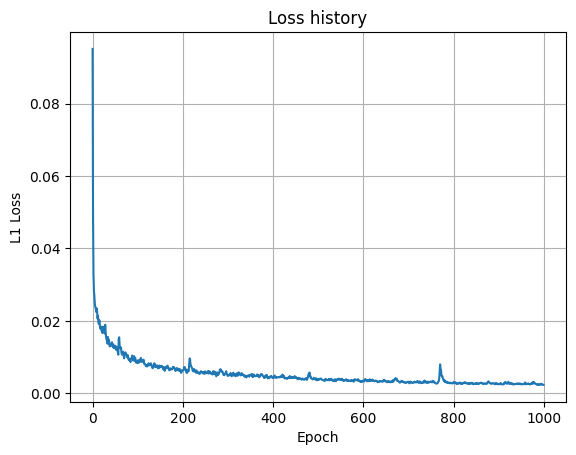

In [18]:
plt.plot(list(range(epochs)), losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Loss history')
plt.show()

In [19]:
# проверка итогового результата
with torch.no_grad():
    model.eval()
    for X, Y in test_dataset:
        X = X[None, :].to(device)
        Y = Y[None, :].to(device)

        outputs = model(X)

        l1_val = criterion(outputs, Y)
        ssim_val = ssim(outputs, Y, data_range=1, size_average=False)

        print(f'L1 оценка: {l1_val}')
        print(f'SSIM оценка: {ssim_val[0]}')

L1 оценка: 0.007770047057420015
SSIM оценка: 0.933279812335968


L1 оценка стремится к 0, а SSIM оценка должна стремиться к 1, что означает полное сходство с оригинальным изображением *(в нашем случае, прогнозом временного ряда)*

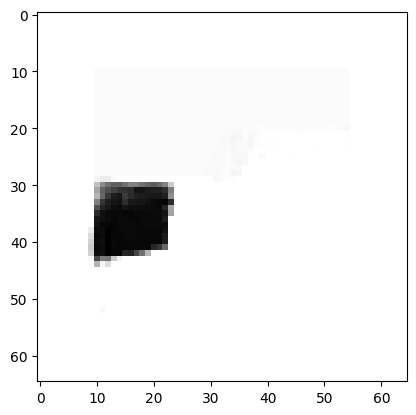

In [20]:
plt.imshow((1-outputs[0].detach().cpu().numpy()[39]), cmap='gray')

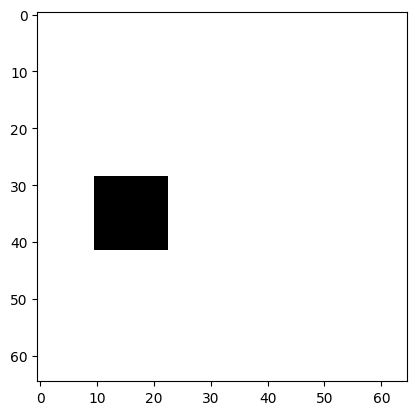

In [21]:
plt.imshow(1 - Y[0].cpu()[39], cmap='gray')

In [22]:
# сохранение результатов в виде gif-файлов
from examples.tools.generating_time_series import save_gif

In [ ]:
%%capture
save_gif(matrices=outputs[0].detach().cpu().numpy(),
         name='predict')

save_gif(matrices=test[-40:],
         name='test')

save_gif(matrices=train,
         name='train')

In [ ]:
# сохранение весов модели
torch.save(model.state_dict(), "model.pth")

Финальный результат представлен ниже (тестовые данные и прогноз на следующие 40 кадров по 120 предыдущим кадрам)

<table>
  <tr>
    <td align="center">
        <b>Тест<b>
      <img src="../tools/media/test.gif">
    </td>
    <td align="center">
        <b>Прогноз<b>
      <img src="../tools/media/predict.gif">
    </td>
  </tr>
</table>

Также вы можете сделать то же самое с 3D или 1D версией сверточной модели Forecaster:

> Примечание: если вы используете 3D свертки, количество каналов будет учитываться с использованием параметра `channel_growth_rate='power'` для того, чтобы сделать модель менее тяжелой. Также ваш параметр input_size должен быть [H, W]. ForecasterBase3d работает только с 2D тензорами, которые создают 3D тензор с временным периодом `in_time_points`.

In [ ]:
forecaster3d = ForecasterBase(input_size=[65, 65],
                              in_time_points=10,
                              out_time_points=5,
                              n_layers=3,
                              normalization='dropout',
                              conv_dim=3,
                              finish_activation_function=nn.ReLU(inplace=True))
forecaster3d

ForecasterBase(
  (encoder): Sequential(
    (conv 1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (conv 2): Sequential(
      (0): Conv3d(4, 9, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (conv 3): Sequential(
      (0): Conv3d(9, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
  )
  (decoder): Sequential(
    (deconv 1): Sequential(
      (0): ConvTranspose3d(16, 9, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (deconv 2): Sequential(
      (0): ConvTranspose3d(9, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (deconv 3): Sequential(
      (0): ConvTranspose3d(4